

# TP Aprentissage Automatiqur II
## Cyprien / Tom

https://www.tensorflow.org/tutorials/images/classification?hl=fr

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from PIL import Image
import tensorflow as tf
import PIL.Image
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow import keras
from keras import layers
from keras.models import Sequential


Fruits 101

In [ ]:
import kagglehub

# Download latest version
path_101 = kagglehub.dataset_download("araraltawil/fruit-101-dataset")

print("Path to dataset files:", path_101)

100%|██████████| 87.5M/87.5M [00:00<00:00, 123MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/araraltawil/fruit-101-dataset/versions/1


 Fruits and Vegetables Classification

In [ ]:
import kagglehub

# Download latest version
path_FandV = kagglehub.dataset_download("muhriddinmuxiddinov/fruits-and-vegetables-dataset")

print("Path to dataset files:", path_FandV)

100%|██████████| 870M/870M [00:07<00:00, 129MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhriddinmuxiddinov/fruits-and-vegetables-dataset/versions/2


In [ ]:
data_101 = Path(path_101)
data_FandV = Path(path_FandV)
#data_Fruits = Path(path_Fruits)

In [ ]:
def count_images(root):
    root = Path(root)
    exts = ["*.jpg", "*.jpeg", "*.png", "*.bmp"]
    files = []
    for ext in exts:
        files += list(root.rglob(ext))
    return len(files), files

for data_dir in [data_101, data_FandV]:

  print(f"Contenu du dossier principal ({data_dir}):")
  # Affiche les premiers éléments pour voir si c'est 'train', 'test' etc.
  for item in data_dir.iterdir():
      print(f" - {item.name}")

for data_dir in [data_101, data_FandV]:
    print(f"\n Dataset : {data_dir}")
    count, files = count_images(data_dir)
    print(f"Nombre total d’images trouvées : {count}")
    if count == 0:
        print("Aucun fichier image trouvé")
    else:
        print("Exemple :")
        for f in files[:5]:
            print(" -", f)

Contenu du dossier principal (/root/.cache/kagglehub/datasets/araraltawil/fruit-101-dataset/versions/1):
 - chery fruit
 - orange
 - banana
 - avocado
 - mango fruit
 - ressberry
 - Apple
 - grapes
Contenu du dossier principal (/root/.cache/kagglehub/datasets/muhriddinmuxiddinov/fruits-and-vegetables-dataset/versions/2):
 - Fruits_Vegetables_Dataset(12000)

 Dataset : /root/.cache/kagglehub/datasets/araraltawil/fruit-101-dataset/versions/1
Nombre total d’images trouvées : 1473
Exemple :
 - /root/.cache/kagglehub/datasets/araraltawil/fruit-101-dataset/versions/1/chery fruit/chery fruit (44).png
 - /root/.cache/kagglehub/datasets/araraltawil/fruit-101-dataset/versions/1/chery fruit/chery fruit (14).png
 - /root/.cache/kagglehub/datasets/araraltawil/fruit-101-dataset/versions/1/chery fruit/chery fruit (64).png
 - /root/.cache/kagglehub/datasets/araraltawil/fruit-101-dataset/versions/1/chery fruit/chery fruit (33).png
 - /root/.cache/kagglehub/datasets/araraltawil/fruit-101-dataset/version

Nombre d'images banana : 180


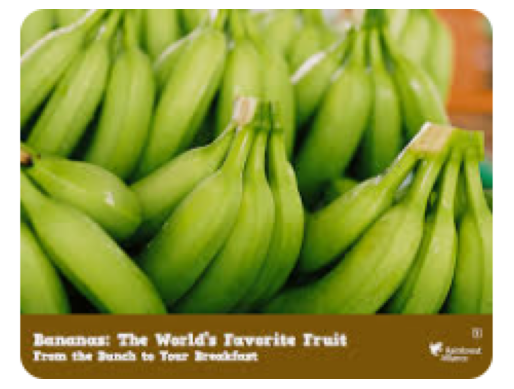

In [ ]:
banana_images = list(data_101.glob("banana/*.png"))
print(f"Nombre d'images banana : {len(banana_images)}")
img = PIL.Image.open(str(banana_images[0]))

plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_101,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1473 files belonging to 8 classes.
Using 1179 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_101,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1473 files belonging to 8 classes.
Using 294 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Apple', 'avocado', 'banana', 'chery fruit', 'grapes', 'mango fruit', 'orange', 'ressberry']


In [ ]:

i=0
distrib = np.zeros(len(class_names))

for i, fruit in enumerate(class_names):
    fruit_images = list(data_101.glob(f"{fruit}/*.png"))
    n = len(fruit_images)
    distrib[i] = n


In [ ]:
print(distrib)

[178. 182. 180. 173. 192. 184. 192. 192.]


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Apple'),
  Text(1, 0, 'avocado'),
  Text(2, 0, 'banana'),
  Text(3, 0, 'chery fruit'),
  Text(4, 0, 'grapes'),
  Text(5, 0, 'mango fruit'),
  Text(6, 0, 'orange'),
  Text(7, 0, 'ressberry')])

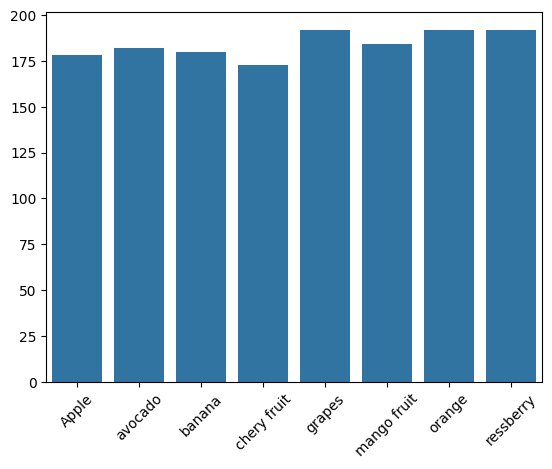

In [ ]:
sns.barplot(x=class_names, y=distrib)
plt.xticks(rotation=45)

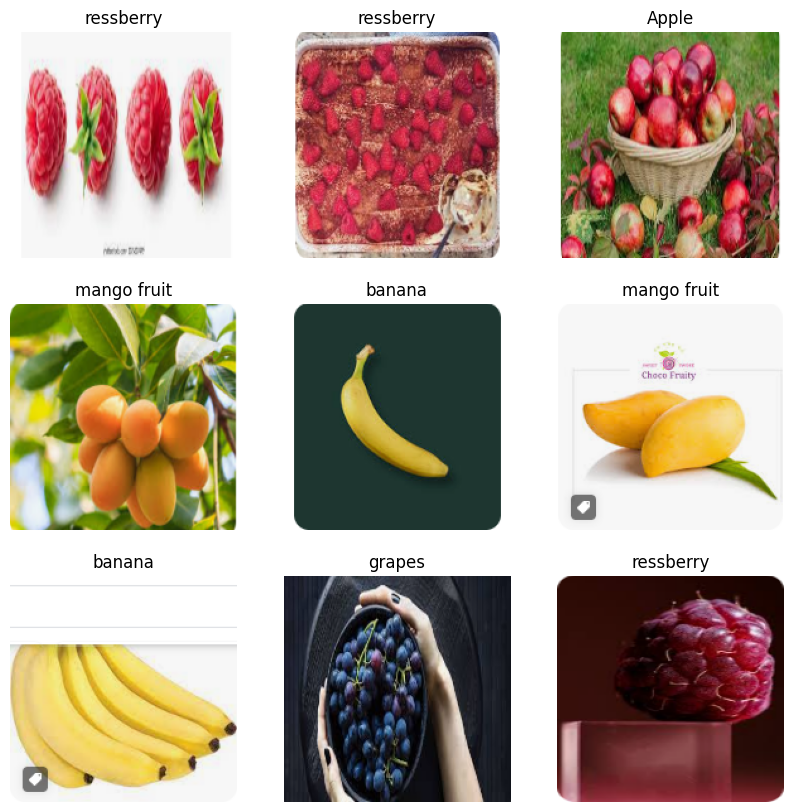

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Preprocessing

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


## CNN Baseline

In [ ]:
num_classes = len(class_names)

#model = tf.keras.Sequential( [
    #tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    #tf.keras.layers.Dense(num_classes)
    #] )
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(num_classes)
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1013888)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │     8,111,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,112,008 (30.94 MB)

 Trainable params: 8,112,008 (30.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 861ms/step - accuracy: 0.1456 - loss: 57.1790 - val_accuracy: 0.3129 - val_loss: 2.7357
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 897ms/step - accuracy: 0.3368 - loss: 2.0249 - val_accuracy: 0.4048 - val_loss: 1.5320
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 868ms/step - accuracy: 0.4292 - loss: 1.5179 - val_accuracy: 0.4660 - val_loss: 1.4098
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 893ms/step - accuracy: 0.4843 - loss: 1.3910 - val_accuracy: 0.5000 - val_loss: 1.3934
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 41s 884ms/step - accuracy: 0.5418 - loss: 1.2725 - val_accuracy: 0.4932 - val_loss: 1.3953
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 33s 885ms/step - accuracy: 0.5595 - loss: 1.2422 - val_accuracy: 0.5408 - val_loss: 1.3453
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 34s 905ms/step - accuracy: 0.5466 - loss: 1.2034 - val_accuracy: 0.4898 - val_loss: 1.4436
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 32s 873ms/step - accuracy: 0.5883 - loss: 1.1561 - val_acc

### OVERFITTING

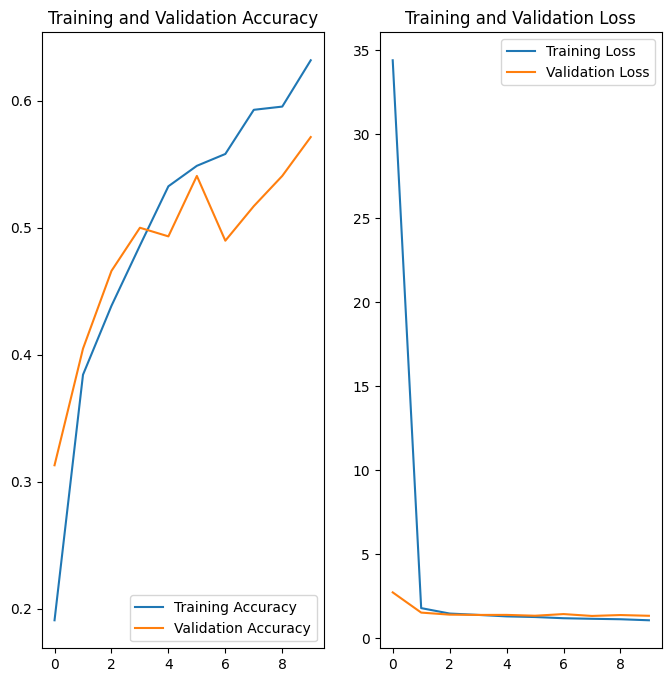

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 1. Load the base model (pre-trained on ImageNet)
base_model = tf.keras.applications.MobileNetV2(input_shape=(180, 180, 3),
                                               include_top=False,
                                               weights='imagenet')

# 2. Freeze the base model
base_model.trainable = False

# 3. Create the full model
model_tl = tf.keras.Sequential([
  layers.Input(shape=(180, 180, 3)),
  data_augmentation,

  # MobileNet expects inputs [-1, 1], so we use its specific preprocessor
  layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input),

  base_model,
  layers.GlobalAveragePooling2D(),
  layers.Dropout(0.2),             # Regularization
  layers.Dense(num_classes)
])

model_tl.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 4. Train
history_tl = model_tl.fit(train_ds, validation_data=val_ds, epochs=10)

/tmp/ipython-input-1895189099.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(180, 180, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.1811 - loss: 2.5031 - val_accuracy: 0.2789 - val_loss: 2.0083
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.2856 - loss: 2.0852 - val_accuracy: 0.3639 - val_loss: 1.7384
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3429 - loss: 1.8317 - val_accuracy: 0.4626 - val_loss: 1.5147
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4260 - loss: 1.6165 - val_accuracy: 0.5612 - val_loss: 1.3427
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4825 - loss: 1.4761 - val_accuracy: 0.6088 - val_loss: 1.2001
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.5319 - loss: 1.3054 - val_accuracy: 0.6463 - val_loss: 1.0824
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.5979 - loss: 1.1584 - val_accuracy: 0.6599 - val_loss: 0.9985
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6020 

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 990ms/step


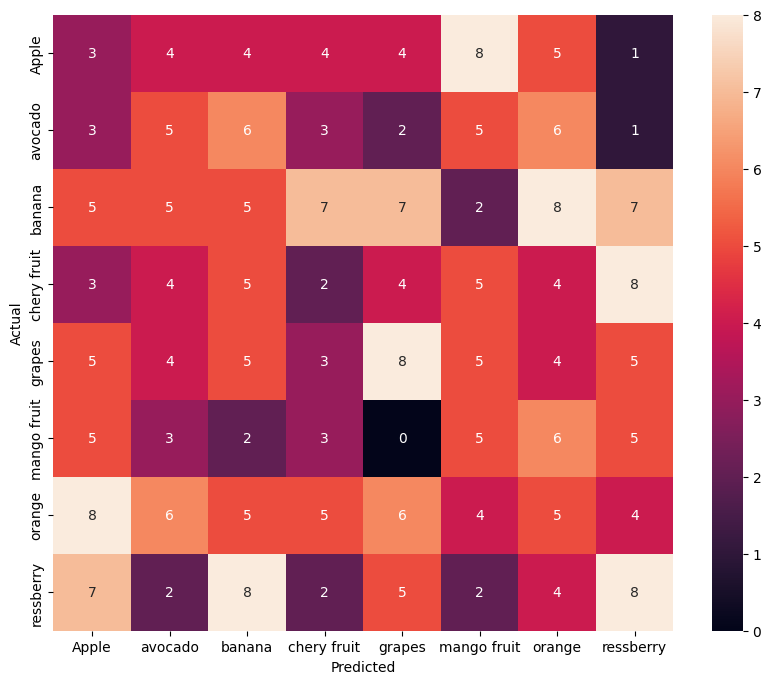

In [ ]:
# Get predictions
y_pred = model_tl.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels (concatenate batches)
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Plot Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### TP2